# License Plate Recognition:

<b> 1.Required Libraries

In [19]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
import cv2
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, Input, Reshape
from tensorflow.keras.utils import to_categorical

<b> 2.Load Datasets

In [22]:

# Paths to the folders
license_detection_folder = r"C:\Users\santhosh\Downloads\Licplatesdetection_train\license_plates_detection_train"
license_recognition_folder = r"C:\Users\santhosh\Downloads\Licplatesrecognition_train\license_plates_recognition_train"
test_folder = r"C:\Users\santhosh\Downloads\test\test\test"
license_detection_csv = r"C:\Users\santhosh\Downloads\Licplatesdetection_train.csv"
license_recognition_csv = r"C:\Users\santhosh\Downloads\Licplatesrecognition_train.csv"

In [24]:
# Load the annotations
license_detection_df = pd.read_csv(license_detection_csv)
license_recognition_df = pd.read_csv(license_recognition_csv)

<b> Data Preprocessing

In [27]:
# Load images and preprocess
def load_images_from_folder(folder, image_size=(224, 224)):
    images = []
    filenames = []
    for filename in os.listdir(folder):
        if filename.endswith('.jpg'):
            img = cv2.imread(os.path.join(folder, filename))
            if img is not None:
                img = cv2.resize(img, image_size)
                images.append(img)
                filenames.append(filename)
    return np.array(images), filenames

license_detection_images, license_detection_filenames = load_images_from_folder(license_detection_folder)
license_recognition_images, license_recognition_filenames = load_images_from_folder(license_recognition_folder)
test_images, test_filenames = load_images_from_folder(test_folder)



In [28]:
# Normalize images
license_detection_images = license_detection_images / 255.0
license_recognition_images = license_recognition_images / 255.0
test_images = test_images / 255.0

In [29]:
# Ensure filenames match between CSV and image folder
license_detection_df['img_id'] = license_detection_df['img_id'].apply(lambda x: x.split('/')[-1])
license_recognition_df['img_id'] = license_recognition_df['img_id'].apply(lambda x: x.split('/')[-1])

# Filter dataframes to only include rows with existing images
license_detection_df = license_detection_df[license_detection_df['img_id'].isin(license_detection_filenames)]
license_recognition_df = license_recognition_df[license_recognition_df['img_id'].isin(license_recognition_filenames)]

# Ensure consistent length
assert len(license_detection_df) == len(license_detection_images)
assert len(license_recognition_df) == len(license_recognition_images)


In [30]:
# Split license detection data into training and validation sets
train_images, val_images, train_labels, val_labels = train_test_split(
    license_detection_images, license_detection_df, test_size=0.2, random_state=42)

<b> 3.Model Detection

In [36]:
# Load pre-trained model and add custom layers

base_model = MobileNetV2(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(1024, activation='relu')(x)
predictions = Dense(4, activation='linear')(x)  # 4 outputs for bounding box coordinates

model = Model(inputs=base_model.input, outputs=predictions)

# Compile the model
model.compile(optimizer='adam', loss='mean_squared_error')

In [38]:
# Convert DataFrame to numpy array for bounding box labels

train_labels = train_labels[['ymin', 'xmin', 'ymax', 'xmax']].values.astype(np.float32)
val_labels = val_labels[['ymin', 'xmin', 'ymax', 'xmax']].values.astype(np.float32)

In [40]:
# Train the model
history = model.fit(train_images, train_labels, validation_data=(val_images, val_labels), epochs=10, batch_size=32)

Epoch 1/10
23/23 ━━━━━━━━━━━━━━━━━━━━ 186s 3s/step - loss: 88309.2891 - val_loss: 83342.7031
Epoch 2/10
23/23 ━━━━━━━━━━━━━━━━━━━━ 63s 3s/step - loss: 10396.1973 - val_loss: 101580.2031
Epoch 3/10
23/23 ━━━━━━━━━━━━━━━━━━━━ 63s 3s/step - loss: 6369.5806 - val_loss: 96069.8438
Epoch 4/10
23/23 ━━━━━━━━━━━━━━━━━━━━ 63s 3s/step - loss: 3850.6821 - val_loss: 71563.4688
Epoch 5/10
23/23 ━━━━━━━━━━━━━━━━━━━━ 99s 4s/step - loss: 1797.0013 - val_loss: 90805.2812
Epoch 6/10
23/23 ━━━━━━━━━━━━━━━━━━━━ 63s 3s/step - loss: 1763.2729 - val_loss: 75723.7266
Epoch 7/10
23/23 ━━━━━━━━━━━━━━━━━━━━ 63s 3s/step - loss: 1145.7023 - val_loss: 45790.6680
Epoch 8/10
23/23 ━━━━━━━━━━━━━━━━━━━━ 63s 3s/step - loss: 1392.9802 - val_loss: 89132.0781
Epoch 9/10
23/23 ━━━━━━━━━━━━━━━━━━━━ 62s 3s/step - loss: 1083.0398 - val_loss: 85233.7656
Epoch 10/10
23/23 ━━━━━━━━━━━━━━━━━━━━ 63s 3s/step - loss: 1120.8645 - val_loss: 75226.9922


<b> 4.Model Recognition

In [43]:
# Define the model
recognition_model = Sequential([
    Input(shape=(224, 224, 3)),
    Conv2D(32, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    Conv2D(128, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    Flatten(),
    Dense(128, activation='relu'),
    Dropout(0.5),
    Dense(10 * 37, activation='softmax'),  # Flattened one-hot vectors, 37 for 0-9, A-Z and padding
    Reshape((10, 37))  # Assuming max 10 characters in license plate
])

# Compile the model
recognition_model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Prepare labels for recognition model
def prepare_labels(df, image_filenames, max_length=10):
    labels = []
    for filename in image_filenames:
        text = df[df['img_id'] == filename]['text'].values[0]
        label = [ord(char) - ord('0') if char.isdigit() else ord(char) - ord('A') + 10 for char in text]
        # Pad label to max_length with 36 (for padding)
        label += [36] * (max_length - len(label))
        labels.append(label)
    return np.array(labels)

recognition_labels = prepare_labels(license_recognition_df, license_recognition_filenames)


In [45]:
# One-hot encode labels
num_classes = 36  # 10 digits + 26 letters
recognition_labels = np.array([to_categorical(label, num_classes + 1) for label in recognition_labels])

In [47]:
# Split data into training and validation sets
train_images, val_images, train_labels, val_labels = train_test_split(
    license_recognition_images, recognition_labels, test_size=0.2, random_state=42)

In [49]:
# Train the recognition model
recognition_history = recognition_model.fit(train_images, train_labels, validation_data=(val_images, val_labels), epochs=10, batch_size=32)


Epoch 1/10
23/23 ━━━━━━━━━━━━━━━━━━━━ 30s 1s/step - accuracy: 0.1997 - loss: 3.2139 - val_accuracy: 0.4544 - val_loss: 1.9395
Epoch 2/10
23/23 ━━━━━━━━━━━━━━━━━━━━ 15s 638ms/step - accuracy: 0.4157 - loss: 2.0785 - val_accuracy: 0.4539 - val_loss: 1.6807
Epoch 3/10
23/23 ━━━━━━━━━━━━━━━━━━━━ 13s 548ms/step - accuracy: 0.4307 - loss: 1.8587 - val_accuracy: 0.4644 - val_loss: 1.6283
Epoch 4/10
23/23 ━━━━━━━━━━━━━━━━━━━━ 13s 553ms/step - accuracy: 0.4485 - loss: 1.7713 - val_accuracy: 0.4650 - val_loss: 1.6037
Epoch 5/10
23/23 ━━━━━━━━━━━━━━━━━━━━ 13s 550ms/step - accuracy: 0.4588 - loss: 1.6993 - val_accuracy: 0.4717 - val_loss: 1.5679
Epoch 6/10
23/23 ━━━━━━━━━━━━━━━━━━━━ 13s 552ms/step - accuracy: 0.4683 - loss: 1.6222 - val_accuracy: 0.4717 - val_loss: 1.5223
Epoch 7/10
23/23 ━━━━━━━━━━━━━━━━━━━━ 13s 561ms/step - accuracy: 0.4814 - loss: 1.5593 - val_accuracy: 0.4844 - val_loss: 1.4922
Epoch 8/10
23/23 ━━━━━━━━━━━━━━━━━━━━ 13s 556ms/step - accuracy: 0.5142 - loss: 1.4580 - val_accurac

<b>5.Prediction and Accuracy

Validation images shape: (180, 224, 224, 3)
Validation labels shape: (180, 10, 37)
6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 120ms/step - accuracy: 0.4989 - loss: 1.4283
Recognition Model Loss: 1.419005274772644
Recognition Model Accuracy: 0.5022222399711609
7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 152ms/step


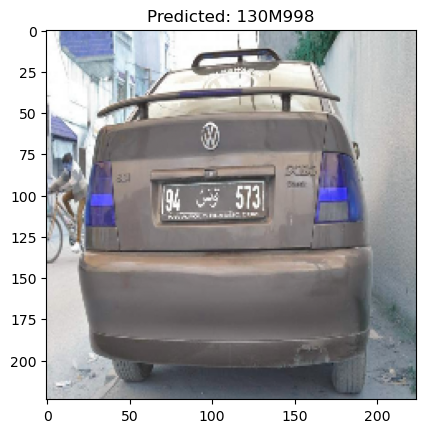

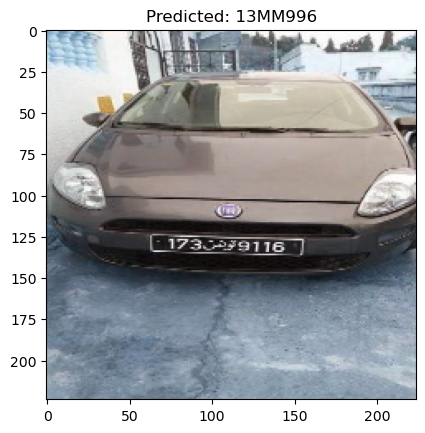

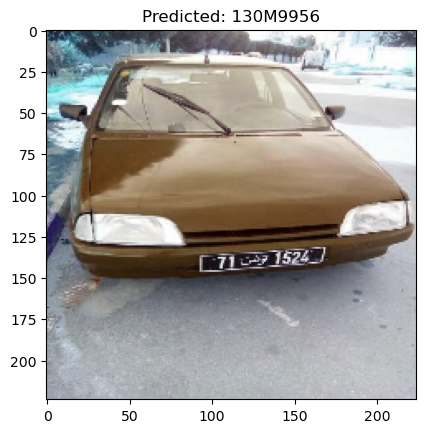

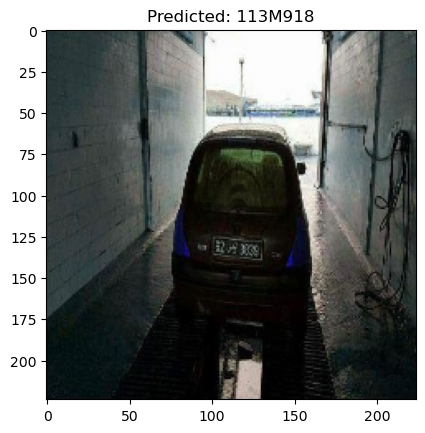

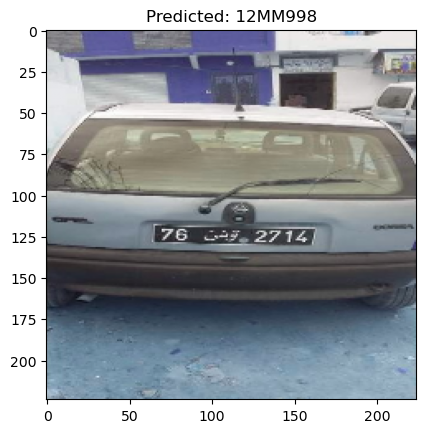

In [52]:
# Ensure val_labels and val_images have correct shapes
print(f"Validation images shape: {val_images.shape}")
print(f"Validation labels shape: {val_labels.shape}")

# Evaluate the recognition model
recognition_loss, recognition_accuracy = recognition_model.evaluate(val_images, val_labels)
print(f"Recognition Model Loss: {recognition_loss}")
print(f"Recognition Model Accuracy: {recognition_accuracy}")

# Make predictions
recognition_predictions = recognition_model.predict(test_images)

# Decode recognition predictions
def decode_predictions(preds, max_length=100):
    decoded_texts = []
    for pred in preds:
        decoded_text = ''.join([chr(np.argmax(char) + ord('0')) if np.argmax(char) < 100 else chr(np.argmax(char) - 100 + ord('A')) for char in pred])
        decoded_texts.append(decoded_text.replace(chr(num_classes + ord('0')), ''))
    return decoded_texts

decoded_texts = decode_predictions(recognition_predictions)

# Display some test results
for i in range(5):
    plt.imshow(test_images[i])
    plt.title(f"Predicted: {decoded_texts[i]}")
    plt.show()


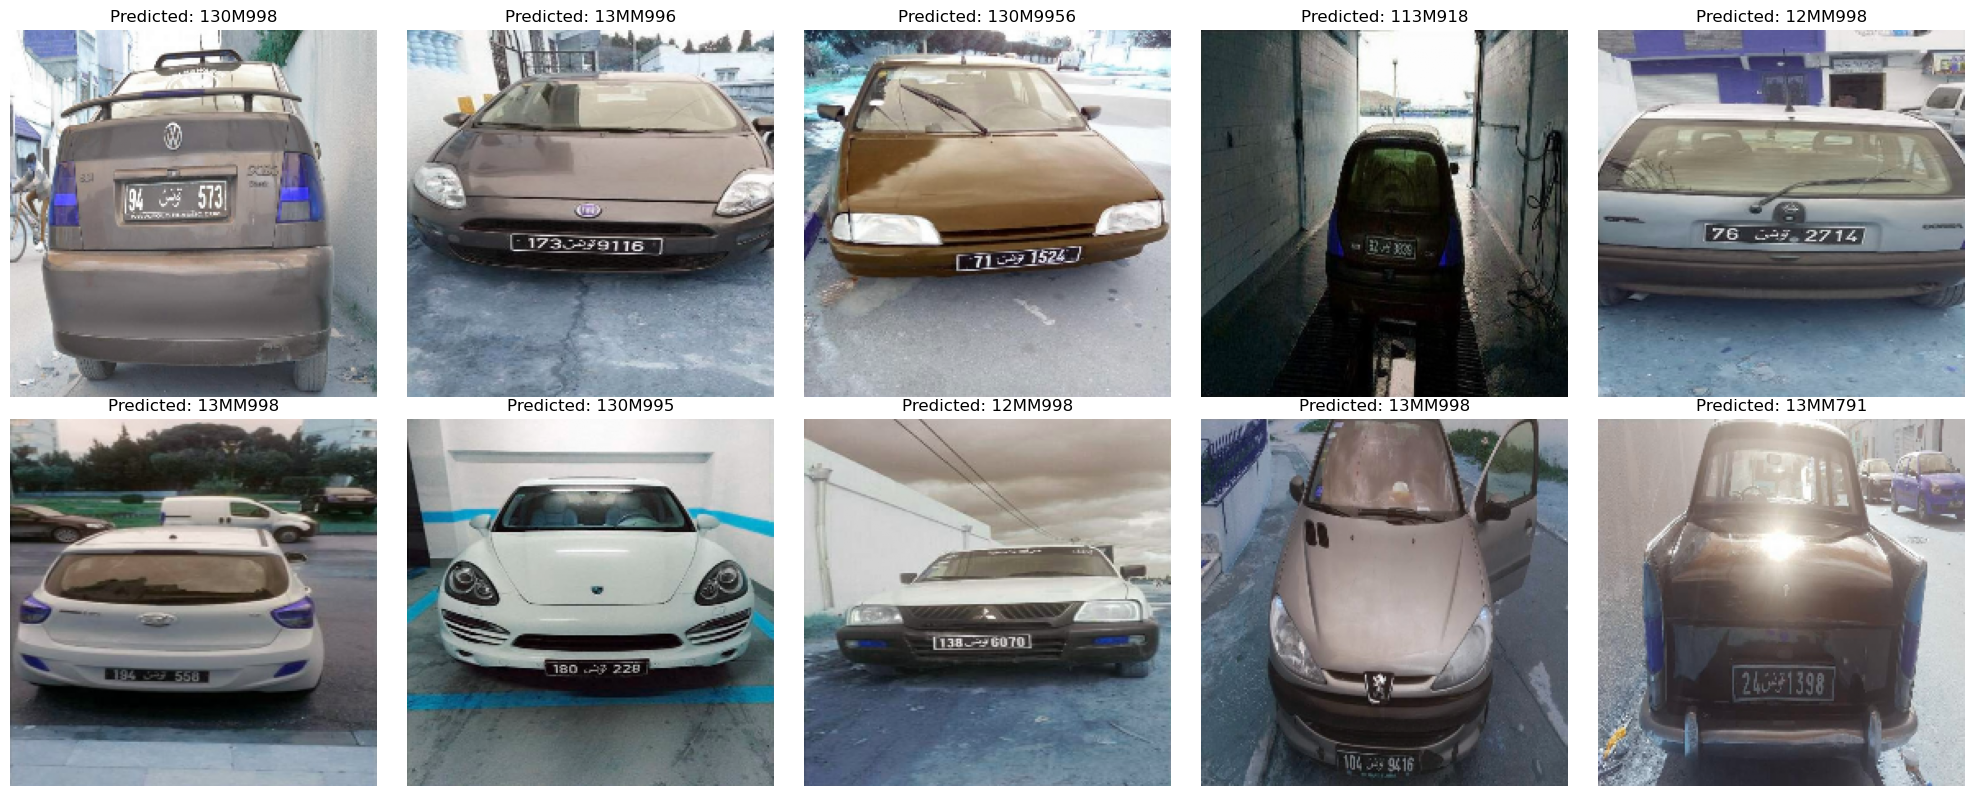

In [54]:
import math
num_samples = 10
rows = math.ceil(num_samples / 5)
plt.figure(figsize=(20, 4 * rows))
for i in range(num_samples):
    plt.subplot(rows, 5, i + 1)
    plt.imshow(test_images[i])
    plt.title(f"Predicted: {decoded_texts[i]}")
    plt.axis('off')
plt.tight_layout()
plt.show()

In [56]:
# Save predictions to submission file
submission_df = pd.DataFrame({'filename': test_filenames, 'text': decoded_texts})
submission_df.to_csv('submission.csv', index=False)

In [58]:
submission_df.head(20)

,filename,text
0,1000.jpg,130M998
1,1001.jpg,13MM996
2,1002.jpg,130M9956
3,1003.jpg,113M918
4,1004.jpg,12MM998
5,1005.jpg,13MM998
6,1006.jpg,130M995
7,1007.jpg,12MM998
8,1008.jpg,13MM998
9,1009.jpg,13MM791
